<a href="https://colab.research.google.com/github/Jeongmin0658/kentech_EF_CCP/blob/main/codes/particle_based/ML/Classification/tensorflow/cnn_example_v0_Oct24_2023_JKedit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Loading the Fashion MNIST dataset from tf.keras.datasets
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Uncomment below to print the first image and label from the training set
# print(train_images[0])
# print(train_labels[0])

# Uncomment below to print the shape of the datasets
# print(train_images.shape)  # Shape of training images
# print(train_labels.shape)  # Shape of training labels
# print(test_images.shape)   # Shape of test images
# print(test_labels.shape)   # Shape of test labels

# Uncomment below to visualize the first 9 images from the training dataset
# plt.figure(figsize=(6,6))
# for i in range(9):
#     plt.subplot(3,3,i+1)
#     plt.title(train_labels[i])
#     plt.imshow(train_images[i])

# Preprocess the data:
# Normalizing the pixel values of images from 0-255 to 0-1 for better performance during training
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define the neural network model:
# - Flatten layer: Flatten the 2D (28 x 28) image to 1D array of 784 pixels
# - Dense layer: Fully connected layer with 512 neurons and ReLU activation
# - Dense layer: Fully connected layer with 10 neurons (one for each label) and softmax activation for classification
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model:
# - Optimizer: 'adam'
# - Loss: 'sparse_categorical_crossentropy' as the labels are integers and not one-hot encoded
# - Metrics: 'accuracy' to monitor during training
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on the training data
model.fit(train_images, train_labels, epochs=10)

# Evaluate the model on the test data
# Returns loss and accuracy
loss, accuracy = model.evaluate(test_images, test_labels)
print(loss, accuracy)  # Print the loss and accuracy of the model on test data


Epoch 1/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.4766 - accuracy: 0.8296
Epoch 2/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.3600 - accuracy: 0.8681
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3211 - accuracy: 0.8809
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2973 - accuracy: 0.8906
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.3389 - accuracy: 0.8776
0.33890029788017273 0.8776000142097473


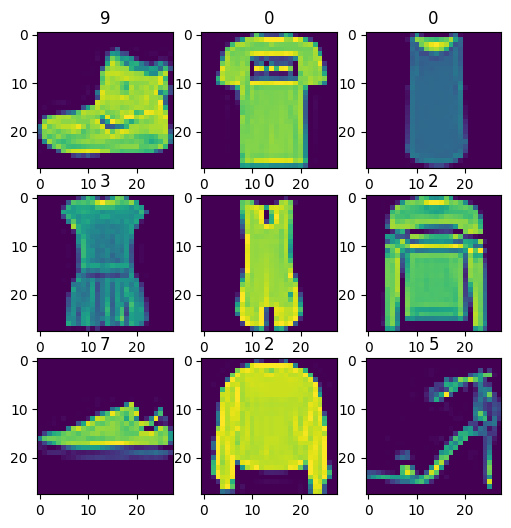

4422102/4422102 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 25s 13ms/step - loss: 0.4740 - accuracy: 0.8305
Epoch 2/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3595 - accuracy: 0.8692
Epoch 3/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.3212 - accuracy: 0.8824
Epoch 4/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3011 - accuracy: 0.8899
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.3802 - accuracy: 0.8646
0.38019251823425293 0.8646000027656555


In [ ]:
# 7. 예측하기
predictions = model.predict(test_images)
print(predictions[4])
print(np.argmax(predictions[4]))

313/313 [==============================] - 1s 2ms/step
[1.0954121e-01 1.5922829e-05 8.4786415e-03 2.0397671e-02 5.0903754e-03
 7.2944771e-05 8.5621077e-01 4.6878972e-06 1.8663945e-04 1.1918763e-06]
6


In [ ]:
class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
input_tensor = # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(281)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

SyntaxError: ignored